In [121]:
# %load VAE_full_test.py
#This is VAE_depth script 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from depth_error import RMSE,ABSR
np.random.seed(0)
tf.set_random_seed(0)
config=tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.4
tf.reset_default_graph()
batch_size=1
num_epochs=100
depthpath="vae_models/depth_"+str(num_epochs)+"_epochs/model"
rgbpath="vae_models/rgb_"+str(num_epochs)+"_epochs/model"
sempath="vae_models/sem_"+str(num_epochs)+"_epochs/model"
fullpath="vae_models/full_"+str(num_epochs)+"_epochs/model"



def xavier_init(fan_in, fan_out, constant=1): 
	""" Xavier initialization of network weights"""
	# https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
	low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
	high = constant*np.sqrt(6.0/(fan_in + fan_out))
	# return tensors
	return tf.random_uniform((fan_in, fan_out), #  shape of the weights
							 minval=low, maxval=high, # here is the range 
							 dtype=tf.float32) # here is the type


class VariationalAutoencoder(object):
	""" Based on See "Auto-Encoding Variational Bayes" by Kingma and Welling
	"""
	def __init__(self, network_architecture,
				 transfer_fct=tf.nn.softplus,learning_rate=1e-3,batch_size=batch_size):
		self.network_architecture=network_architecture# which is a dictionary 
		self.transfer_fct=transfer_fct
		self.learning_rate=learning_rate
		self.batch_size=batch_size
		# tf Graph input
		self.x=tf.placeholder(tf.float32,[None, network_architecture["n_input"]])
		# Create auotencoder 
		self.create_network()
		# define loss function based on variational upper bound 
		# and corresponding optimizer 
		self.create_loss_optimizer()
		#self.saver=tf.train.Saver()


	def initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
							n_hidden_gener_1,  n_hidden_gener_2, 
							n_input, n_z):
		# create a dictionary of tensor variables 
		all_weights = dict()
		# recognition  network
		all_weights['weights_recog'] = {
			'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
			'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
			'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
			'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
		all_weights['biases_recog'] = {
			'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
			'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
			'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
			'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
		# generate network 
		all_weights['weights_gener'] = {
			'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
			'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
			'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
			'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
		all_weights['biases_gener'] = {
			'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
			'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
			'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
			'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
		return all_weights
	
	def create_network(self):
		# create tensor variables for  weights and bias
		self.network_weights=self.initialize_weights(**self.network_architecture) 
		# network_weights  is a dictionary 
		# pass architecture parameters 
		# network_architecture is a dictionary 

		# recognition network :
		#input: data x shape [batch_size,n_x]
		#output : mean of z , log(variance^2) shape [batch_size,n_z]
		# pass variables to network 
		self.z_mean, self.z_log_sigma_sq = \
			self.recognition_network(self.network_weights["weights_recog"], 
									 self.network_weights["biases_recog"])
			
		n_z = self.network_architecture["n_z"]# dimension of z
		
		
		eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32) 
		# standard Normal
		# z = z_mean + z_sigma*epsilon
		
		self.z = tf.add(self.z_mean, tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))
		#shape [batch_size,n_z]
		
		# Generate network :
		# input z
		# output mean of pixels shape[batch_Size,n_x]
		# multivariant Gaussian Distribution
		self.x_reconstr_mean = \
			self.generator_network(self.network_weights["weights_gener"],
								   self.network_weights["biases_gener"])
	
	def recognition_network(self, weights, biases):
		# Generate probabilistic encoder (recognition network), which
		# maps inputs onto a normal distribution in latent space.
		# The transformation is parametrized and can be learned.
		layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
										   biases['b1'])) 
		layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
										   biases['b2'])) 
		z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
						biases['out_mean'])
		
		z_log_sigma_sq =\
			tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
				   biases['out_log_sigma'])
			
		return (z_mean, z_log_sigma_sq)
	
	# use variables to buld generate network 
	def generator_network(self, weights, biases):
		# Generate probabilistic decoder (decoder network), which
		# maps points in latent space onto a Bernoulli distribution in data space.
		# The transformation is parametrized and can be learned.
		layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
										   biases['b1'])) 
		layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
										   biases['b2'])) 
		
		# depth estimation mean 
		x_reconstr_mean = \
		   tf.add(tf.matmul(layer_2, weights['out_mean']), 
								 biases['out_mean'])
		#x_reconstr_sigma= \
		#     tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
		#                        biases['out_log_sigma'])
		return x_reconstr_mean
	
	def create_loss_optimizer(self):
		# The loss is composed of two terms:
		
		# 1.) The reconstruction loss (the negative log probability
		#     of the input under the reconstructed Bernoulli/Gaussian distribution 
		#     induced by the decoder in the data space).
		#     This can be interpreted as the number of "nats" required
		#     for reconstructing the input when the activation in latent
		#     is given.
		# Adding 1e-10 to avoid evaluation of log(0.0)
		# Assuem identity gaussian 
		
		# loss from generative data 
 
		# 1) bernouli distribution
		"""
		reconstr_loss =-tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
						   + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
						   axis=1)
		"""
		# 1) gaussian distribution
		reconstr_error=self.x-self.x_reconstr_mean
		reconstr_loss=tf.reduce_sum(tf.square(reconstr_error),axis=1)
		# 2.) The latent loss, which is defined as the Kullback Leibler divergence 
		##    between the distribution in latent space induced by the encoder on 
		#     the data and some prior. This acts as a kind of regularizer.
		#     This can be interpreted as the number of "nats" required
		#     for transmitting the the latent space distribution given
		#     the prior.
		#     closed form of  KL  divergence with gaussian distribution
		latent_loss=-0.5*tf.reduce_sum(1+self.z_log_sigma_sq 
										   -tf.square(self.z_mean) 
										   -tf.exp(self.z_log_sigma_sq), axis=1)
		self.cost = tf.reduce_mean(reconstr_loss + latent_loss) # average over batch
		# Use ADAM optimizer
		self.optimizer = \
			tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
			

	def partial_fit(self, X):
		"""
		Train model based on mini-batch of input data.
		Return cost of mini-batch.
		"""
		opt,cost = sess.run((self.optimizer, self.cost), 
								  feed_dict={self.x: X})
		return cost


#Build  network for depth channel
with tf.variable_scope("depth"):
	network_architecture_depth= \
	   dict(n_hidden_recog_1=1000, # 1st layer encoder neurons
		 n_hidden_recog_2=1000, # 2nd layer encoder neurons
		 n_hidden_gener_1=1000, # 1st layer decoder neurons
		 n_hidden_gener_2=1000, # 2nd layer decoder neurons
		 n_input=1080, # MNIST data input (img shape: 28*28)
		 n_z=50)  # dimensionality of latent space
	vae_depth=VariationalAutoencoder(network_architecture_depth,learning_rate=0.001,batch_size=batch_size)

listvar=vae_depth.network_weights
var_depth=(list(listvar['weights_recog'].values())
	+list(listvar['biases_recog'].values())
	+list(listvar['weights_gener'].values())
	+list(listvar['biases_gener'].values()))
saver_depth=tf.train.Saver(var_depth)


# Build network for semantics  channel
with tf.variable_scope("RGB"):
	network_architecture_rgb= \
		dict(n_hidden_recog_1=1000, # 1st layer encoder neurons
			n_hidden_recog_2=1000, # 2nd layer encoder neurons
			n_hidden_gener_1=1000, # 1st layer decoder neurons
			n_hidden_gener_2=1000, # 2nd layer decoder neurons
			n_input=1080*3, # MNIST data input (img shape: 28*28)
			n_z=50)  # dimensionality of latent space
	vae_rgb=VariationalAutoencoder(network_architecture_rgb,learning_rate=0.001,batch_size=batch_size)
  
listvar2=vae_rgb.network_weights
var_rgb=(list(listvar2['weights_recog'].values())
	+list(listvar2['biases_recog'].values())
	+list(listvar2['weights_gener'].values())
	+list(listvar2['biases_gener'].values()))
saver_rgb=tf.train.Saver(var_rgb)


# Build network for semantic channels
with tf.variable_scope("Sem"):
	network_architecture_Sem = \
		dict(n_hidden_recog_1=2000, # 1st layer encoder neurons
		 n_hidden_recog_2=2000, # 2nd layer encoder neurons
		 n_hidden_gener_1=2000, # 1st layer decoder neurons
		 n_hidden_gener_2=2000, # 2nd layer decoder neurons
		 n_input=5400, # MNIST data input (img shape: 28*28)
		 n_z=100)  # dimensionality of latent space
	vae_Sem=VariationalAutoencoder(network_architecture_Sem,learning_rate=1e-4,batch_size=batch_size)

listvar3=vae_Sem.network_weights
var_Sem=(list(listvar3['weights_recog'].values())
	+list(listvar3['biases_recog'].values())
	+list(listvar3['weights_gener'].values())
	+list(listvar3['biases_gener'].values()))
saver_Sem=tf.train.Saver(var_Sem)


########################    Start build  shared information fusion   #############################
with tf.variable_scope("Full"):
	network_architecture_Full = \
		dict(n_hidden_recog_1=50, # 1st layer encoder neurons
		 n_hidden_recog_2=50, # 2nd layer encoder neurons
		 n_hidden_gener_1=50, # 1st layer decoder neurons
		 n_hidden_gener_2=50, # 2nd layer decoder neurons
		 n_input=200, # MNIST data input (img shape: 28*28)
		 n_z=2)  # dimensionality of latent space
	#vae_Sem= VariationalAutoencoder(network_architecture_Sem,learning_rate=1e-4, batch_size=100)
	vae_Full=VariationalAutoencoder(network_architecture_Full,learning_rate=1e-4,batch_size=batch_size)

listvar4=vae_Full.network_weights
var_Full=(list(listvar4['weights_recog'].values())
	+list(listvar4['biases_recog'].values())
	+list(listvar4['weights_gener'].values())
	+list(listvar4['biases_gener'].values()))
saver_Full=tf.train.Saver(var_Full)

# load data

In [122]:
depth_data=np.load("../Data/depth_data.npy")
depthmask_data=np.load("../Data/depth_mask.npy")
Depth_input=depth_data[:,:,:,0].reshape(-1,1080)[0:37000]# shape [size,1080]
Depthmask_input=depthmask_data[:,:,:,0].reshape(-1,1080)[0:37000]

RGB_data=np.load("../Data/rgb_data.npy")
R_data=RGB_data[:,:,:,0].reshape(-1,1080)
G_data=RGB_data[:,:,:,1].reshape(-1,1080)
B_data=RGB_data[:,:,:,2].reshape(-1,1080)
RGB_input=np.concatenate((R_data,G_data,B_data),axis=1)[0:37000] #shape[size,3*1080]

Sem_data=np.load("../Data/sem_data.npy")
Ground_input=Sem_data[:,:,:,0].reshape(-1,1080)
Objects_input=Sem_data[:,:,:,1].reshape(-1,1080)
Building_input=Sem_data[:,:,:,2].reshape(-1,1080)
Vegetation_input=Sem_data[:,:,:,3].reshape(-1,1080)
Sky_input=Sem_data[:,:,:,4].reshape(-1,1080)
Sem_input=np.concatenate((Ground_input,Objects_input,
						  Building_input,Vegetation_input,Sky_input),
						  axis=1)[0:37000]# shape[size,5*1080]
print(Sem_input.shape)
print(RGB_input.shape)
print(Depth_input.shape)
n_samples=Sem_input.shape[0] 
############################ Finish Load data ###################################

(30602, 5400)
(30602, 3240)
(30602, 1080)


# load model 

In [145]:
### Initialization
init=tf.global_variables_initializer()
sess=tf.Session(config=config)
sess.run(init)
###Load  other models 
saver_depth.restore(sess,depthpath)
print("loaded model weights from "+depthpath)
saver_rgb.restore(sess,rgbpath)
print("loaded model weights from "+rgbpath)
saver_Sem.restore(sess,sempath)
print("loaded model weights from "+sempath)
######################## variables list #########################

train_new_model=False
if train_new_model:    
	vae_Full.train(batch_size=100, training_epochs=1)
	saver_Full.save(sess,fullpath)
	print("saved the vae model weights to "+fullpath)
else:
	saver_Full.restore(sess,fullpath)
	print("loaded the vae model weights from"+fullpath)
################################  make predictions  ##########################

############################# Load test data ################################
#z1_depth=sess.run(vae_depth.z_mean,feed_dict={vae_depth.x:Depth_input[1000:1001]*0})
#z1_rgb=sess.run(vae_rgb.z_mean,feed_dict={vae_rgb.x:RGB_input[1000:1001]})
#z1_sem=sess.run(vae_Sem.z_mean,feed_dict={vae_Sem.x:Sem_input[1000:1001]*0})
#z1_in=np.concatenate((z1_rgb,z1_depth,z1_sem),axis=1)
#z1=sess.run(vae_Full.z_mean,feed_dict={vae_Full.x:z1_in})

#z_depth_out=sess.run(vae_Full.x_reconstr_mean,feed_dict={vae_Full.x:z1_in})[0:1,50:100]
depth_out=sess.run(vae_depth.x_reconstr_mean,feed_dict={vae_depth.x:Depth_input[2000:2001]})
#[:,50:100]
#depth_mean=sess.run(vae_depth.x_reconstr_mean,feed_dict={vae_depth.z:z1})#[:,50:100]
#depth_var=sess.run(vae_depth.,feed_dict={vae_depth.z:z1})
#z2_depth=sess.run(vae_depth.z_mean,feed_dict={vae_depth.x:Depth_input[10000:10001]*0})
#z2_rgb=sess.run(vae_rgb.z_mean,feed_dict={vae_rgb.x:RGB_input[10000:10001]})
#z2_sem=sess.run(vae_Sem.z_mean,feed_dict={vae_Sem.x:Sem_input[10000:10001]*0})
#z2_in=np.concatenate((z2_rgb,z2_depth,z2_sem),axis=1)
#z2=sess.run(vae_Full.z_mean,feed_dict={vae_Full.x:z2_in})#[:,50:100]
#depth_mean2=sess.run(vae_depth.x_reconstr_mean,feed_dict={vae_depth.z:z2})#[:,50:100]
"""
z2_in=np.concatenate((z2_rgb,z2_depth,z2_sem),axis=1)
z2=sess.run(vae_Full.z,feed_dict={vae_Full.x:z2_in})
z3_depth=sess.run(vae_depth.z_mean,feed_dict={vae_depth.x:Depth_input[0:1]*0})
z3_rgb=sess.run(vae_rgb.z_mean,feed_dict={vae_rgb.x:RGB_input[0:1]})
z3_sem=sess.run(vae_Sem.z_mean,feed_dict={vae_Sem.x:Sem_input[0:1]})
z3_in=np.concatenate((z3_rgb,z3_depth,z3_sem),axis=1)
z3=sess.run(vae_Full.z_mean,feed_dict={vae_Full.x:z3_in})
z4_depth=sess.run(vae_depth.z_mean,feed_dict={vae_depth.x:Depth_input[10000:10001]*0})
z4_rgb=sess.run(vae_rgb.z_mean,feed_dict={vae_rgb.x:RGB_input[10000:10001]})
z4_sem=sess.run(vae_Sem.z_mean,feed_dict={vae_Sem.x:Sem_input[10000:10001]})
z4_in=np.concatenate((z4_rgb,z4_depth,z4_sem),axis=1)
z4=sess.run(vae_Full.z_mean,feed_dict={vae_Full.x:z4_in})
z5_depth=sess.run(vae_depth.z_mean,feed_dict={vae_depth.x:Depth_input[0:1]})
z5_rgb=sess.run(vae_rgb.z_mean,feed_dict={vae_rgb.x:RGB_input[0:1]})
z5_sem=sess.run(vae_Sem.z_mean,feed_dict={vae_Sem.x:Sem_input[0:1]})
z5_in=np.concatenate((z5_rgb,z5_depth,z5_sem),axis=1)
z5=sess.run(vae_Full.z_mean,feed_dict={vae_Full.x:z5_in})
z6_depth=sess.run(vae_depth.z_mean,feed_dict={vae_depth.x:Depth_input[10000:10001]})
z6_rgb=sess.run(vae_rgb.z_mean,feed_dict={vae_rgb.x:RGB_input[10000:10001]})
z6_sem=sess.run(vae_Sem.z_mean,feed_dict={vae_Sem.x:Sem_input[10000:10001]})
z6_in=np.concatenate((z6_rgb,z6_depth,z6_sem),axis=1)
z6=sess.run(vae_Full.z_mean,feed_dict={vae_Full.x:z6_in})
"""
sess.close()

INFO:tensorflow:Restoring parameters from vae_models/depth_100_epochs/model
loaded model weights from vae_models/depth_100_epochs/model
INFO:tensorflow:Restoring parameters from vae_models/rgb_100_epochs/model


InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on vae_models/rgb_100_epochs/model: Not found: vae_models/rgb_100_epochs; No such file or directory
	 [[Node: save_1/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/RestoreV2/tensor_names, save_1/RestoreV2/shape_and_slices)]]

Caused by op 'save_1/RestoreV2', defined at:
  File "/Users/yi/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/yi/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-121-b3187ee4e41b>", line 226, in <module>
    saver_rgb=tf.train.Saver(var_rgb)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1218, in __init__
    self.build()
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1227, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1263, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 751, in _build_internal
    restore_sequentially, reshape)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 427, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 267, in restore_op
    [spec.tensor.dtype])[0])
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1021, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/Users/yi/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to get matching files on vae_models/rgb_100_epochs/model: Not found: vae_models/rgb_100_epochs; No such file or directory
	 [[Node: save_1/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/RestoreV2/tensor_names, save_1/RestoreV2/shape_and_slices)]]


In [ ]:
%matplotlib inline

In [ ]:
plt.imshow(depth_out[0].reshape(18,60),cmap='jet')

In [119]:
depth_data.shape

(30602, 18, 60, 1)

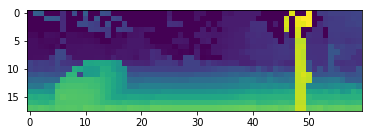

In [144]:
plt.imshow(depth_data[1000,:,:,0])#,cmap='jet')

In [39]:
pwd

'/Users/yi/Desktop/yi/project/bitbucket/mae_tensorflow'

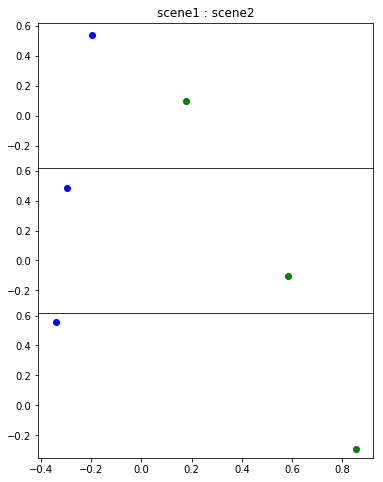

In [38]:
f, (ax1, ax2, ax3) = plt.subplots(3,figsize=(6,8), sharex=True, sharey=True)
ax1.scatter(z1[:,0],z1[:,1],c='b')
ax1.scatter(z2[:,0],z2[:,1],c='g')
ax1.set_title('scene1 : scene2')
ax2.scatter(z3[:,0],z3[:,1],c='b')
ax2.scatter(z4[:,0],z4[:,1],c='g')
ax3.scatter(z5[:,0],z5[:,1],c='b')
ax3.scatter(z6[:,0],z6[:,1],c='g')
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.savefig('scene1_2_training.png')

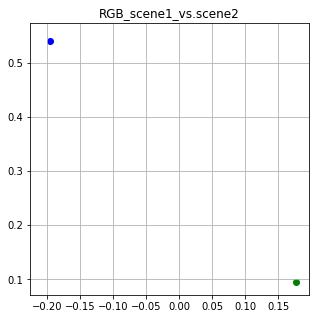

In [29]:
plt.figure(figsize=(5,5)) 
#plt.scatter(z1[:,0],z1[:,1],c='b')# RGBDS
plt.title('RGB_scene1_vs.scene2')
#plt.scatter(z2[:,0],z2[:,1],c='g')#RGB
plt.scatter(z3[:,0],z3[:,1],c='b')# RGBS
plt.scatter(z4[:,0],z4[:,1],c='g')
#plt.colorbar()
plt.grid()
#plt.savefig('rgbs.png')

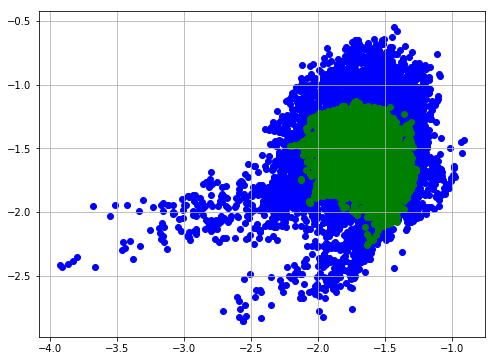

In [8]:
plt.figure(figsize=(8,6)) 
plt.scatter(z1[:,0],z1[:,1],c='b')# RGBDS
plt.scatter(z2[:,0],z2[:,1],c='g')#RGB
#plt.scatter(z3[:,0],z3[:,1],c='r')# RGBS
#plt.scatter(z4[:,0],z4[:,1],c='r')
#plt.colorbar()
plt.grid()